In [270]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler


In [271]:
# Config & Setup Details
cfg_batch_size  = 20
cfg_max_epochs  = 10
cfg_num_workers = 2

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"
cfg_data_url_test  = "https://s3.amazonaws.com/mtsu.csci.7850.project/test.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "data-loader"


In [272]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [273]:
# Load Data - Parse the Date Column
df_raw = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Train Shape: {df_raw.shape}")

print(df_raw.head())

# Format Date Column to DateTime
df_raw['date'] = pd.to_datetime(df_raw['date'], format=cfg_data_date_fmt)

df_grouped_date_store = df_raw.groupby(['date', 'store'])['sales'].sum().reset_index()
df_grouped_date = df_raw.groupby(['date'])['sales'].sum().reset_index()

print(df_grouped_date)
print(df_grouped_date_store)

# Pivot the DataFrame
df_train = df_grouped_date_store.pivot(index='date', columns='store', values='sales')

# Resetting the index
df_train = df_train.reset_index()

# Show the New Table
print(df_train)
print(df_train.columns)



Train Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]
            date  store  sales
0     2013-01-01      1   1316
1     2013-01-01      2   1742
2     2013-01-01      3   1588
3     2013-01-01      4   1423
4     2013-01-01      5   1032
...          ...    ...    ...
18255 2017-12-31      6   2009
18256 2017-12-31      7   1831
18257 2017-12-31      8   3205
18258 2017-12-31      9   2774
18259 2017-12-31     10   2939

[18260 rows x 3 columns]
store       date     1     2     3     4     5     6     7     8     9    10
0

In [274]:
df_train.columns

df = df_train

df.set_index('date', inplace=True)
print(df.shape)

(1826, 10)


In [275]:
# Normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Create sequences
seq_length = 30
x, y = create_sequences(df_scaled, seq_length)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training and testing sets
train_size = int(0.8 * len(X_tensor))
x_train = x_tensor[:train_size]
y_train = y_tensor[:train_size]
x_val = x_tensor[train_size:]
y_val = y_tensor[train_size:]

In [276]:
x_train.shape

torch.Size([1436, 30, 10])

In [277]:
class LSTMModel(pl.LightningModule):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 num_layers,
                 **kwargs):
        super().__init__(**kwargs)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_size, output_size)
        self.loss = nn.MSELoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    # No complications with regression...
    def predict(self, x):
        return self(x)
    
    def forward(self, x):
        y = x
        
        # Initialize hidden state and cell state
        h0 = torch.zeros(num_layers, y.size(0), hidden_size).to(y.device)
        c0 = torch.zeros(num_layers, y.size(0), hidden_size).to(y.device)

        # Forward propagate LSTM
        y, _ = self.lstm(y, (h0, c0))
        y = y[:, -1, :] # Extract only the last time ste
        y = self.linear(y)
        return y

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y_true = train_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss


# Model parameters
input_size = 10  # Number of features (sales data from 10 stores)
hidden_size = 50  # Number of features in hidden state
output_size = 10  # Number of output values (e.g., future sales prediction)
num_layers = 4  # Number of stacked LSTM layers

# Create the LSTM model
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [278]:
summary(model, input_data=torch.Tensor(x_train[0:5]).float())

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [5, 10]                   --
├─LSTM: 1-1                              [5, 30, 50]               73,600
├─Linear: 1-2                            [5, 10]                   510
Total params: 74,110
Trainable params: 74,110
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 11.04
Input size (MB): 2.15
Forward/backward pass size (MB): 0.06
Params size (MB): 0.30
Estimated Total Size (MB): 2.51

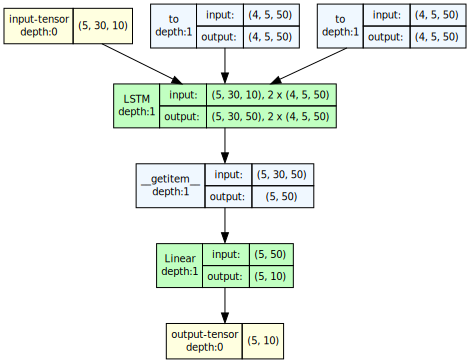

In [279]:
model_graph = draw_graph(model,
                         input_data=torch.Tensor(x_train[0:5]).float(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [280]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train).float(),
                                                torch.Tensor(y_train).float())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_val).float(), 
                                              torch.Tensor(y_val).float())), 
                                     shuffle=False, 
                                     batch_size=batch_size, 
                                     num_workers=cfg_num_workers)

In [281]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Project",
                              version="1.0.0")

In [282]:
trainer = pl.Trainer(logger=logger, max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [283]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning:

Experiment logs directory lightning_logs/Project/1.0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.33108314871788025    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.33108314871788025}]

In [284]:
trainer.fit(model, xy_train, xy_val) 


  | Name   | Type    | Params
-----------------------------------
0 | lstm   | LSTM    | 73.6 K
1 | linear | Linear  | 510   
2 | loss   | MSELoss | 0     
-----------------------------------
74.1 K    Trainable params
0         Non-trainable params
74.1 K    Total params
0.296     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [285]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_loss,epoch,step,train_loss
0,0.331083,0,0,NaN
1,0.021168,0,71,NaN
2,NaN,0,71,0.050022
3,0.016685,1,143,NaN
4,NaN,1,143,0.013550
5,0.015621,2,215,NaN
6,NaN,2,215,0.012400
7,0.016980,3,287,NaN
8,NaN,3,287,0.012146
9,0.014875,4,359,NaN


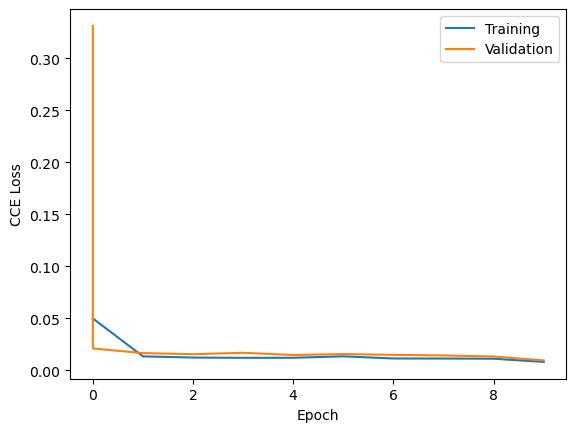

In [286]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("CCE Loss") 
plt.xlabel("Epoch") 
plt.show()